In [77]:
'''This repository contains a detailed implementation of the Reinforcement Learning Enviroment class'''
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import *
from typing import Any, Callable, Dict, List, Tuple, Union, Optional
import scipy.integrate as integrate
import sys
sys.path.insert(0, '/Users/niyi/Documents/GitHub/Optimal-Control/Tools')
from EnforceTyping import EnforceClassTyping, enforce_method_typing
from ParticlesandFields import ClassicalField, ClassicalParticle
from MDPFramework import MDPEnvironment,  LearningAgent

ImportError: cannot import name 'LearningAgent' from 'MDPFramework' (/Users/niyi/Documents/GitHub/Optimal-Control/Tools/MDPFramework.py)

**Vector Field**

In [ ]:
@dataclass(kw_only=True)
class ElectrostaticField2D(ClassicalField):
  """
  A class used to represent a 2D Electrostatic Field

  Attributes
  ----------
  field_sources: dict
      a formatted string to print out what the animal says
  dimensionality: tuple
      a tuple of the dimensionality of the field  

  Methods
  -------
  dynamics(self, observation_position: np.ndarray, time: float) -> np.ndarray:
      Represents the value of the field at any given point(s) or time. 
  potential(self, observation_position: np.ndarray, time: float) -> float:
      Represents the potential due to the field at a given position and/or time  
  potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray, time: float) -> float:
      Represents the potential difference between two positions at a given time in the vector field   
  gradient(self, observation_position: np.ndarray, time: float) -> float:
      Represents the gradient at a given position and/or time in the vector field 
  curl(self, observation_position: np.ndarray, time: float) -> float:
      Represents the curl at a given position and/or time in the vector field 
  divergence(self, observation_position: np.ndarray, time: float) -> float:
      Represents the divergence at a given position and/or time in the vector field
  """
  field_sources: dict
  dimensionality: tuple = (2,)

  def __call__(self, observation_position: np.ndarray) -> np.ndarray:
      return self.dynamics(observation_position)

  @enforce_method_typing
  def dynamics(self, observation_position: np.ndarray) -> np.ndarray:
      """
      This function outputs the field strength due to field sources experienced at any given point(s) or time. 
      This determines the physics of the field (a 2D Electricstatic Field in this case)

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric field strength vector at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_field_vector = np.zeros_like(observation_position)
      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_field_vector += (displacement_vector * field_source.charge) / displacement_magnitude**3
      electric_field_vector = coulomb_constant * electric_field_vector
      return np.round(electric_field_vector, 3)  # N/C or V/m

  @enforce_method_typing
  def potential(self, observation_position: np.ndarray) -> float:
      """
      Calculate the potential (voltage) at a position in the field.

      Args:
          observation_position (np.ndarray): The position.

      Returns:
          np.ndarray: The electric potential at the given position.
      """
      assert len(self.field_sources["Particle"]) == len(self.field_sources["Position"]), "The length of particles and fields don't match"
      for field_source, _ in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          assert isinstance(field_source, ClassicalParticle),  "The field source is not a particle"
  
      coulomb_constant = 8.9875e9  # N*m^2/C^2
      electric_potential = 0.0

      for field_source, source_position in zip(self.field_sources["Particle"], self.field_sources["Position"]):
          position_matrices = np.broadcast_to(source_position, reversed(observation_position.shape)).T
          displacement_vector = observation_position - position_matrices
          displacement_magnitude = np.linalg.norm(displacement_vector, axis=0)
          electric_potential += field_source.charge / displacement_magnitude

      electric_potential = coulomb_constant * electric_potential
      return np.round(electric_potential, 3)  # V

  @enforce_method_typing
  def potential_difference(self, initial_position: np.ndarray, final_position: np.ndarray) -> float:
    """
    Calculate the potential difference between the initial position and the final position in the field.

    Args:
        initial_position (np.ndarray): The starting position.
        final_position (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    assert initial_position.shape == self.dimensionality, "initial_position has the wrong dimensions"
    assert final_position.shape == self.dimensionality, "final_position has the wrong dimensions"
    PorentialDifference= self.potential(initial_position)- self.potential(final_position)
    return PorentialDifference

  def gradient(self, observation_position: np.ndarray, delta: float= 0.001)->np.ndarray:
    """
    This function returns the derivative of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    gradient= np.zeros_like(observation_position)
    for i in range(len(observation_position)):
      di= np.zeros_like(observation_position)
      di[i, ] = di[i, ]+delta
      plusdi= observation_position+ di
      minusdi= observation_position- di
      gradient[i]= (self.dynamics(plusdi)- self.dynamics(minusdi))[i]/ (2* delta)
    return gradient
  
  def curl(self, observation_position: np.ndarray)-> float:
    """
    This function returns the curl of the field at a given point

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  
  def divergence(self, observation_position: np.ndarray)-> float:
    """
    This function returns the divergence of the field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    pass
  @enforce_method_typing
  def plot_field(self, low_bound= -20, high_bound= 20):
    """
    This funtion plots the 2D electric vector field

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    observation_position= np.meshgrid(np.linspace(low_bound, high_bound, 25), 
                                    np.linspace(low_bound, high_bound, 25))
    observation_position= np.stack(observation_position)
    xd, yd = self.dynamics(observation_position)
    xd = xd / np.sqrt(xd**2 + yd**2)
    yd = yd / np.sqrt(xd**2 + yd**2)
    color_aara = np.sqrt(xd**2+ yd**2)
    fig, ax = plt.subplots(1,1)
    cp = ax.quiver(observation_position[0],observation_position[1],xd,yd,color_aara)
    fig.colorbar(cp)
    plt.rcParams['figure.dpi'] = 150
    plt.show()

**Example 1: Particle in Field Environment**

In [ ]:
@dataclass(kw_only=True)
class ParticleInField(MDPEnvironment):
  """
  A class used to represent a particle in a Field

  Attributes
  ----------
  field: ClassicalField
    The field that the particle is in 
  particle: ClassicalParticle
    The particle that is in the field
  target: np.ndarray 
    The target position of the particle
  distance_weight: float 
    The weight of the distance between the particle and the target
  energy_weight: float 
    The weight of the energy of the particle
  terminal_signal_weight: float 
    The weight of the terminal signal of the particle
  current_time: float 
    The current time of the system

  Methods
  ------- 
  transition_model(self, state: State, action: Any)-> State: 
    Represents the  
  reward_model(self, state: State, action: Any, next_state: State, terminal_signal: bool)-> float:
    Represents the reward of the system
  is_terminal_condition(self, state: State)-> bool: 
    Represents the terminal condition of the system
  transition_step(self, state: State, action: Any)-> tuple[float, State, bool]: 
    Represents the transition step of the system
  sample_trajectory(self, runtime: float)-> list[State]: 
    Samples a trajectory of the system
  trajectory_value(self, trajectory: list[State])-> float: 
    Represents the value of the trajectory
  reset(self): 
    Resets the system

  """
  field: ClassicalField
  particle: ClassicalParticle
  target: np.ndarray # m
  distance_weight: float= 1.0
  energy_weight: float= -1.0
  terminal_signal_weight: float= -1000.0
  current_time: float = 0.0# s
  
  @dataclass 
  class State(EnforceClassTyping):
    '''This class represents the state of the Agent with its position, velocity and the Field Strength if experiences at its position. 
    These are parameters the agent is able to observe, they uniquely define the state of the agent.'''
    position: np.ndarray # m
    velocity: np.ndarray #m/s
    
    def vector(self):
      return np.concatenate([self.position, self.velocity])
    
  initial_state: State = None
  current_state: State = None

  def __post_init__(self):
    if self.initial_state is None:
        self.initial_state= self.random_state()
    self.current_state= self.initial_state
  @enforce_method_typing
  def state_dynamics(self, state: np.ndarray, time: float, control_force: np.ndarray):
    """
    Compute the dynamics of the particle's state.

    Parameters:
    state (np.ndarray): The current state of the particle [x, y, vx, vy].
    time (float): The current time.
    control_force (np.ndarray): The external control force applied to the particle.

    Returns:
    np.ndarray: The derivative of the state [vx, vy, ax, ay].
    """
    velocity = state[2:]
    acceleration = (self.particle.charge * self.field.dynamics(state[:2]) + control_force) / self.particle.mass
    return np.concatenate((velocity, acceleration))
  
  @enforce_method_typing
  def transition_model(self, state: State, action: np.ndarray= np.array([0.0, 0.0]), timeInterval:float= 1.0)-> State:
    """
    Outputs the state of the system after taking an action(applying a constant force for *timeInterval* seconds)

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    Posx, Posy, Velx, Vely= integrate.odeint(self.state_dynamics, state.vector(), [self.current_time, self.current_time+ timeInterval], args=(action,))[-1]
    Currrentposition= np.array([Posx, Posy])
    Currentvelocity= np.array([Velx, Vely])
    return self.State(Currrentposition, Currentvelocity)
  @enforce_method_typing
  def reward_model(self, state: State, action: np.ndarray, next_state: State, terminal_signal: bool)-> float:
    """
    This method determines how the agent is rewarded given a state transition. 
    The reward determines the behaviour the agent should learn(i.e getting to the target and using the least amount of energy).

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    DistanceGainedFromtarget= np.linalg.norm(state.position-self.target)- np.linalg.norm(next_state.position-self.target) 
    EnergyConsumed= self.particle.charge* self.field.potential(state.position, next_state.position)
    Cost= self.distance_weight* DistanceGainedFromtarget+ self.energy_weight* EnergyConsumed+ self.terminal_signal_weight* terminal_signal
    return Cost
  
  @enforce_method_typing
  def is_terminal_condition(self, state: State)-> bool: 
    """
    This method determines if the state is within the viable learning region of the environment: Constraints

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    WithinXBound= -10. <= state.position[0] <= 10.
    WithinYBound= -10. <= state.position[1] <= 10. 
    WithinvelocityBound= np.linalg.norm(state.velocity) < 10. 
    if WithinXBound and WithinYBound and WithinvelocityBound: 
        return False    
    else:
        return True
  @enforce_method_typing
  def transition_step(self, state: State= current_state, action: np.ndarray= np.array([0.0, 0.0]), time_interval: float= 1.0):
    """
    Outputs the state of the system after taking an action, the reward ocurring from the transition and the terminal signal

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    next_state= self.transition_model(state, action, timeInterval=time_interval)
    TerminalSignal= self.is_terminal_condition(next_state) 
    Reward= self.reward_model(state, action, next_state, TerminalSignal)
    return next_state, Reward, TerminalSignal

  def random_state(self)->State: 
    """
    This method generates a random state within the viable learning region

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    random_position= np.random.uniform(-10., 10., size= self.field.dimensionality)
    random_velocity= np.zeros_like(random_position)
    return self.State(random_position, random_velocity)

  @enforce_method_typing
  def sample_trajectory(self, runtime: float, Policy: Optional[Callable]= None, timeStep: int=0.1):
    """
    This method generates a random state within the viable learning region

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    time= [0]
    State= self.current_state
    StateTrajectory= []
    ActionTrajectory= []
    while time[-1]<runtime: 
      StateTrajectory.append(State)
      if Policy is Callable:
        Action = Policy(State)
      else:
          Action = np.random.randn(2)
      ActionTrajectory.append(Action)
      State= self.transition_model(State, Action, timeInterval= timeStep) 
      time.append(time[-1]+timeStep) 
    return StateTrajectory, ActionTrajectory, time

  @enforce_method_typing
  def plot_trajectory(self, StateTrajectory: list, time: list):
    """
    This method generates a random state within the viable learning region

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    positionPath= [State.position for State in StateTrajectory]
    velocityPath= [State.velocity for State in StateTrajectory]
    positionTrajectory= np.stack(positionPath).T
    velocityTrajectory= np.stack(velocityPath).T
    plt.plot(positionTrajectory[0], positionTrajectory[1])
    plt.plot(positionTrajectory[0][0], positionTrajectory[1][0], 'ko')
    plt.plot(positionTrajectory[0][-1], positionTrajectory[1][-1], 'r*')
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.grid(True)
    plt.show()

  @enforce_method_typing
  def trajectory_value(self, StateTrajectory: list, ActionTrajectory: list, time: list)-> float:
    """
    This method generates a random state within the viable learning region

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    Value= 0
    timeInterval= (time[-1]-time[0])/len(time)
    for State, Action in zip(StateTrajectory, ActionTrajectory):
        Value= Value+ (np.linalg.norm(State.position-self.target)+np.linalg.norm(Action))* timeInterval
    return Value
  
  def reset(self):
    """
    This method generates a random state within the viable learning region

    Args:
        InitialPosition (np.ndarray): The starting position.
        FinalPosition (np.ndarray): The ending position.
        resolution (int, optional): The number of intervals to divide the path into. Defaults to 5000.

    Returns:
        float: The work required to move from the initial position to the final position.
    """
    self.current_state= self.initial_state
    self.current_time= 0.0


In [ ]:
negativeCharge= ClassicalParticle(mass=1.0, charge= -1e-9)
positiveCharge= ClassicalParticle(mass=1.0, charge= 1e-9)
sources = {"Particle": [negativeCharge, positiveCharge],
           "Position": [np.array([1.0, 1.0]), np.array([-1.0, 1.0])]}
testElectricField= ElectrostaticField2D(field_sources=sources)


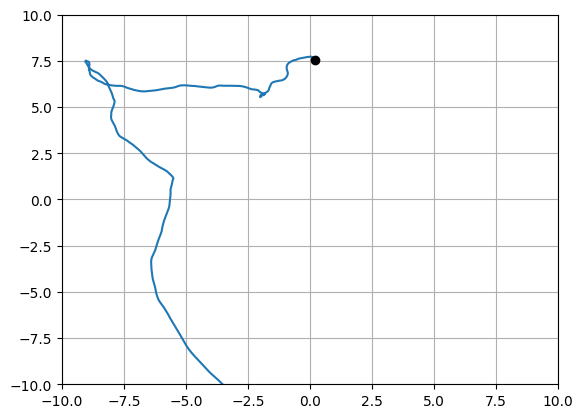

519.5572390342493

In [ ]:
PositiveChargeInElectricField= ParticleInField(field=testElectricField, 
                                               particle=positiveCharge, 
                                               target=np.array([0.0, 0.0]))
StateTrajectory, ActionTrajectory, Time= PositiveChargeInElectricField.sample_trajectory(50.0)
Return= PositiveChargeInElectricField.trajectory_value(StateTrajectory, ActionTrajectory, Time)
PositiveChargeInElectricField.plot_trajectory(StateTrajectory, Time)
Return